<a href="https://colab.research.google.com/github/kridtapon/HMA-SMI-PowerTrade/blob/main/HMA_SMI_PowerTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate the Hull Moving Average (HMA)
def calculate_hma(data, period):
    """
    Calculate the Hull Moving Average (HMA).
    """
    wma_half = data['Close'].ewm(span=period // 2).mean()
    wma_full = data['Close'].ewm(span=period).mean()
    hma = (2 * wma_half - wma_full).ewm(span=int(np.sqrt(period))).mean()
    return hma

# Function to calculate the Stochastic Momentum Index (SMI)
def calculate_smi(data, period=14, smooth_k=3, smooth_d=3):
    """
    Calculate the Stochastic Momentum Index (SMI).
    """
    high_max = data['High'].rolling(window=period).max()
    low_min = data['Low'].rolling(window=period).min()
    smi = 100 * (data['Close'] - (high_max + low_min) / 2) / (high_max - low_min)
    smi = smi.ewm(span=smooth_k).mean()  # Smooth K
    smi = smi.ewm(span=smooth_d).mean()  # Smooth D
    return smi

# Define the stock symbol and time period
symbol = 'TPL'  # UAL GDDY TPL
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate SMI and HMA indicators
smi_period = 14  # Set your desired period for SMI
fast_hma_period = 7  # Set your desired period for fast HMA
slow_hma_period = fast_hma_period * 2  # Set your desired period for slow HMA

df['SMI'] = calculate_smi(df, period=smi_period)
df['Fast_HMA'] = calculate_hma(df, period=fast_hma_period)
df['Slow_HMA'] = calculate_hma(df, period=slow_hma_period)

# Define Entry and Exit signals based on fast and slow HMA crossovers
df['Entry'] = (df['Fast_HMA'] > df['Slow_HMA']) & (df['SMI'] > -40)  # Fast HMA crosses above Slow HMA
df['Exit'] = (df['Fast_HMA'] < df['Slow_HMA']) & (df['SMI'] < 40)  # Fast HMA crosses below Slow HMA

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           492580.958509
Total Return [%]                       392.580959
Benchmark Return [%]                   370.656037
Max Gross Exposure [%]                      100.0
Total Fees Paid                      46955.709631
Max Drawdown [%]                        40.333042
Max Drawdown Duration                       414.0
Total Trades                                   78
Total Closed Trades                            77
Total Open Trades                               1
Open Trade PnL                       -25120.39613
Win Rate [%]                            44.155844
Best Trade [%]                          39.893401
Worst Trade [%]                         -9.374444
Avg Winning Trade [%]                   10.586784
Avg Losing Trade [%]                    -3.739406


In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to calculate the Hull Moving Average (HMA)
def calculate_hma(data, period):
    wma_half = data['Close'].ewm(span=period // 2).mean()
    wma_full = data['Close'].ewm(span=period).mean()
    hma = (2 * wma_half - wma_full).ewm(span=int(np.sqrt(period))).mean()
    return hma

# Function to calculate the Stochastic Momentum Index (SMI)
def calculate_smi(data, period=14, smooth_k=3, smooth_d=3):
    high_max = data['High'].rolling(window=period).max()
    low_min = data['Low'].rolling(window=period).min()
    smi = 100 * (data['Close'] - (high_max + low_min) / 2) / (high_max - low_min)
    smi = smi.ewm(span=smooth_k).mean()  # Smooth K
    smi = smi.ewm(span=smooth_d).mean()  # Smooth D
    return smi

# Download the data
symbol = 'TPL'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Parameter ranges for optimization
smi_period_range = range(5, 31)
fast_hma_period_range = range(5, 31)
slow_hma_multiplier = 2  # Fixed multiplier for slow HMA

# Store results
results = []

# Iterate over all parameter combinations
for smi_period, fast_hma_period in product(smi_period_range, fast_hma_period_range):
    slow_hma_period = fast_hma_period * slow_hma_multiplier

    # Calculate indicators
    df['SMI'] = calculate_smi(df, period=smi_period)
    df['Fast_HMA'] = calculate_hma(df, period=fast_hma_period)
    df['Slow_HMA'] = calculate_hma(df, period=slow_hma_period)

    # Define Entry and Exit signals
    df['Entry'] = (df['Fast_HMA'] > df['Slow_HMA']) & (df['SMI'] > -40)
    df['Exit'] = (df['Fast_HMA'] < df['Slow_HMA']) & (df['SMI'] < 40)

    # Filter data for the test period
    test_df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=test_df['Close'],
        entries=test_df['Entry'],
        exits=test_df['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    performance = portfolio.total_return()
    results.append((smi_period, fast_hma_period, performance))

# Find the best parameters
best_params = max(results, key=lambda x: x[2])  # Sort by performance
best_smi_period, best_fast_hma_period, best_performance = best_params
print("Best Parameters (SMI Period, Fast HMA Period, Performance):", best_params)

# Re-run backtest with the best parameters
best_slow_hma_period = best_fast_hma_period * slow_hma_multiplier
df['SMI'] = calculate_smi(df, period=best_smi_period)
df['Fast_HMA'] = calculate_hma(df, period=best_fast_hma_period)
df['Slow_HMA'] = calculate_hma(df, period=best_slow_hma_period)

df['Entry'] = (df['Fast_HMA'] > df['Slow_HMA']) & (df['SMI'] > -40)
df['Exit'] = (df['Fast_HMA'] < df['Slow_HMA']) & (df['SMI'] < 40)

# Filter data for the test period
test_df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=test_df['Close'],
    entries=test_df['Entry'],
    exits=test_df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics for the best parameters
print(portfolio.stats())

# Visualize the portfolio for the best parameters
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Best Parameters (SMI Period, Fast HMA Period, Performance): (29, 5, 7.138165095663283)
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           813816.509566
Total Return [%]                        713.81651
Benchmark Return [%]                   370.656037
Max Gross Exposure [%]                      100.0
Total Fees Paid                      62142.398121
Max Drawdown [%]                        35.649402
Max Drawdown Duration                       337.0
Total Trades                                   93
Total Closed Trades                            93
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            40.860215
Best Trade [%]                           71.77878
Worst Trade [%]                         -7.603326
Avg Winning T

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



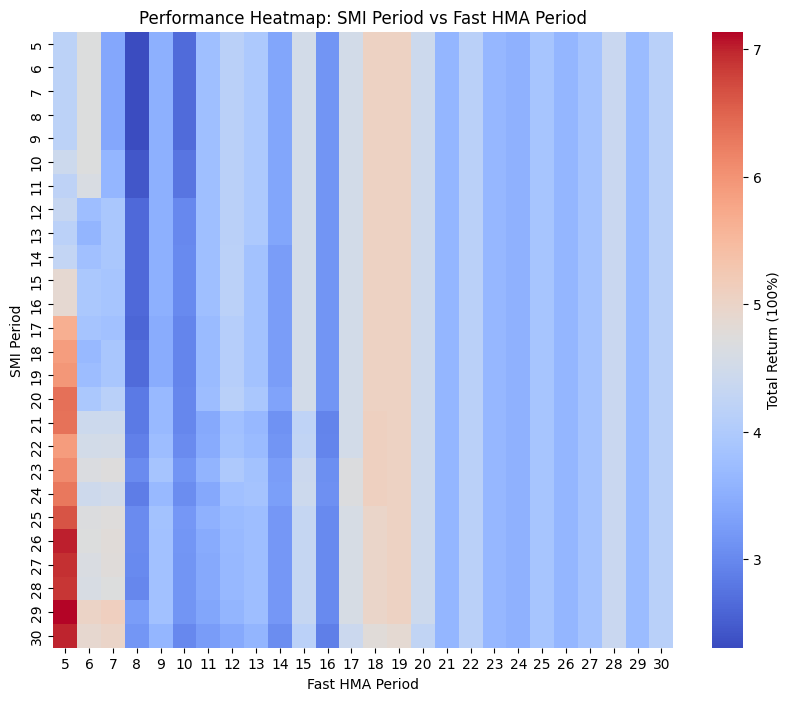

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from results
results_df = pd.DataFrame(results, columns=['SMI_Period', 'Fast_HMA_Period', 'Performance'])

# Pivot the DataFrame for heatmap
heatmap_data = results_df.pivot(index='SMI_Period', columns='Fast_HMA_Period', values='Performance')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Total Return (100%)'})
plt.title('Performance Heatmap: SMI Period vs Fast HMA Period')
plt.xlabel('Fast HMA Period')
plt.ylabel('SMI Period')
plt.show()
